In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from scipy import stats
from sklearn import neighbors, datasets
from sklearn import linear_model as lm
import warnings; warnings.simplefilter('ignore')
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics
import math

df = pd.read_csv('wdbc.csv')
df['diagnosis'] = pd.Categorical(df.diagnosis).codes

<h1> 1 Explore the Data

In [42]:
summaryDF = df[df.columns.difference(['id', 'diagnosis'])]

summary = pd.DataFrame(index=summaryDF.columns)
summary['Mean'] = summaryDF.mean()
summary['STD'] = summaryDF.std()
summary['NumMissing'] = summaryDF.isnull().sum()
summary.index.name = "Variables"
l = []
listofname = summaryDF.columns
for x in listofname:
    l.append(np.corrcoef(df[x], df['diagnosis'])[0,1])
summary["Correlation"] = l

print(summary)

                         Mean         STD  NumMissing  Correlation
Variables                                                         
area.mean          654.889104  351.914129           0     0.708984
area.se             40.337079   45.491006           0     0.548236
area.worst         880.583128  569.356993           0     0.733825
compactness.mean     0.104341    0.052813           0     0.596534
compactness.se       0.025478    0.017908           0     0.292999
compactness.worst    0.254265    0.157336           0     0.590998
concavity.mean       0.088799    0.079720           0     0.696360
concavity.se         0.031894    0.030186           0     0.253730
concavity.worst      0.272188    0.208624           0     0.659610
concpoints.mean      0.048919    0.038803           0     0.776614
concpoints.se        0.011796    0.006170           0     0.408042
concpoints.worst     0.114606    0.065732           0     0.793566
fracdim.mean         0.062798    0.007060           0    -0.01

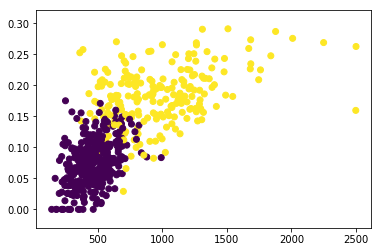

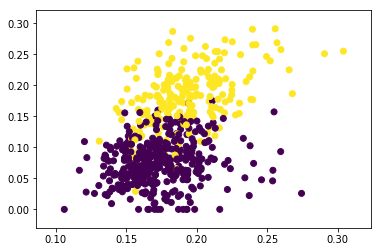

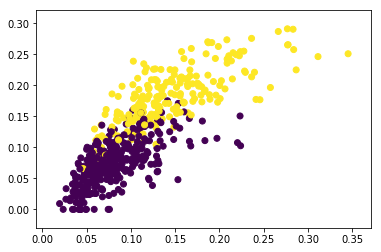

In [43]:
plt.scatter(df['area.mean'], df['concpoints.worst'], c=df['diagnosis'])
plt.show()
plt.scatter(df['symmetry.mean'], df['concpoints.worst'], c=df['diagnosis'])
plt.show()
plt.scatter(df['compactness.mean'], df['concpoints.worst'], c=df['diagnosis'])
plt.show()

<h1> 2 Decision Boundary

<h3> 2.1 KNN Case

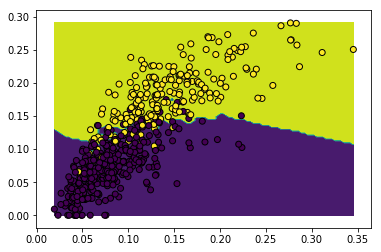

In [44]:
X = df[['compactness.mean','concpoints.worst']].values
Y = df['diagnosis']
knn=neighbors.KNeighborsClassifier(n_neighbors = 3)
knn.fit(X, Y)
x_min, x_max = X[:,0].min(), X[:,0].max()
y_min, y_max = X[:,1].min(), X[:,1].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx,yy,Z)
plt.scatter(df['compactness.mean'], df['concpoints.worst'], c=df['diagnosis'], edgecolor='black')
plt.show()

It seems that KNN fits this model relatively well and does well on picking up the actual shape. However, I am concerened that it is picking up to much noise and is a victim of overfitting.

<h3> 2.2 Logistic Regression

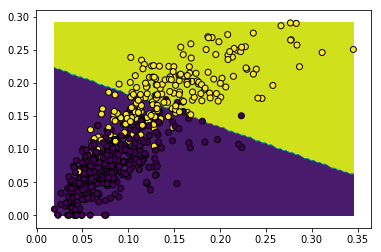

In [45]:
LogReg = lm.LogisticRegression()
LogReg.fit(X, Y)
Z = LogReg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx,yy,Z)
plt.scatter(df['compactness.mean'], df['concpoints.worst'], c=df['diagnosis'], edgecolor='black')
plt.show()

Compared to the KNN example above, the logistic regression is way underfitted and does not hold the actual shape well. Using logistic regression is a good model for this data.

<h3> 2.3 Feature Engineering

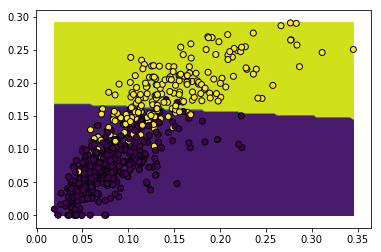

In [49]:
X = df[['compactness.mean','concpoints.worst']]
Y = df['diagnosis']
X['x**2'] = X['compactness.mean'] ** 3
X['y**2'] = X['concpoints.worst'] ** 3
X['x*y'] = X['compactness.mean'] * df['concpoints.worst']
X['x+y'] = X['compactness.mean'] - df['concpoints.worst']

LogReg = lm.LogisticRegression()
LogReg.fit(X, Y)
Z = LogReg.predict(np.c_[xx.ravel(), yy.ravel(), xx.ravel()**3, yy.ravel()**3, xx.ravel() * yy.ravel(), xx.ravel() - yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx,yy,Z)
plt.scatter(df['compactness.mean'], df['concpoints.worst'], c=df['diagnosis'], edgecolor='black')
plt.show()

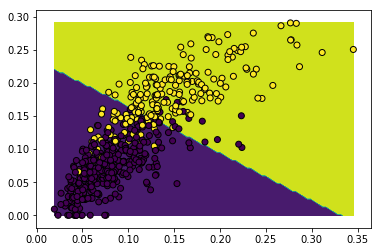

In [50]:
X = df[['compactness.mean','concpoints.worst']]
Y = df['diagnosis']
X['x**2'] = X['compactness.mean'] ** 2
X['y**2'] = X['concpoints.worst'] ** 2
X['x*y'] = X['compactness.mean'] * df['concpoints.worst']
X['x+y'] = X['compactness.mean'] + df['concpoints.worst']

LogReg = lm.LogisticRegression()
LogReg.fit(X, Y)
Z = LogReg.predict(np.c_[xx.ravel(), yy.ravel(), xx.ravel()**2, yy.ravel()**2, xx.ravel() * yy.ravel(), xx.ravel() + yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx,yy,Z)
plt.scatter(df['compactness.mean'], df['concpoints.worst'], c=df['diagnosis'], edgecolor='black')
plt.show()

I believe that this last model x^2 is the best model for a logistic regression with feature engineering. It does a good job of fitting the data without over or underfitting. Although its still holds some problems with defining the actual shape of the data.

<h1> 3 Using the Full Data

In [51]:
X = df[df.columns.difference(['id', 'diagnosis'])]
Y = df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

LogReg = lm.LogisticRegression()
LogReg.fit(X_train, y_train)
predictions = LogReg.predict(X_test)
accuracy = metrics.r2_score(y_test, predictions)
recall = metrics.recall_score(y_test, predictions)
precision = metrics.precision_score(y_test, predictions)
print("Logistic Regression")
print("Accuracy", accuracy)
print("Recall", recall)
print("Precision", precision)

print()
print("Cross Validation")
LogReg = lm.LogisticRegression()
LogReg.fit(X_train, y_train)
predictions = cross_val_predict(LogReg, X, Y, cv=100)
accuracy = metrics.r2_score(Y, predictions)
recall = metrics.recall_score(Y, predictions)
precision = metrics.precision_score(Y, predictions)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print()
print()

for l in np.linspace(10**-6, 10**6, 10):
    LogReg = lm.LogisticRegression(C=l)
    LogReg.fit(X_train, y_train)
    predictions = cross_val_predict(LogReg, X, Y, cv=100)
    accuracy = metrics.r2_score(Y, predictions)
    recall = metrics.recall_score(Y, predictions)
    precision = metrics.precision_score(Y, predictions)
    print("Lambda:", l)
    print("Accuracy:", accuracy)
    print("Recall:", recall)
    print("Precision:", precision)
    print()
    print()

Logistic Regression
Accuracy 0.746586217847
Recall 0.914893617021
Precision 0.934782608696

Cross Validation
Accuracy: 0.789493155753
Recall: 0.919811320755
Precision: 0.946601941748


Lambda: 1e-06
Accuracy: 0.594022514666
Recall: 0.806603773585
Precision: 0.929347826087


Lambda: 111111.111112
Accuracy: 0.819565562074
Recall: 0.938679245283
Precision: 0.947619047619


Lambda: 222222.222223
Accuracy: 0.819565562074
Recall: 0.933962264151
Precision: 0.951923076923


Lambda: 333333.333334
Accuracy: 0.812047460494
Recall: 0.938679245283
Precision: 0.943127962085


Lambda: 444444.444445
Accuracy: 0.812047460494
Recall: 0.929245283019
Precision: 0.951690821256


Lambda: 555555.555556
Accuracy: 0.819565562074
Recall: 0.938679245283
Precision: 0.947619047619


Lambda: 666666.666667
Accuracy: 0.827083663654
Recall: 0.943396226415
Precision: 0.947867298578


Lambda: 777777.777778
Accuracy: 0.804529358913
Recall: 0.933962264151
Precision: 0.942857142857


Lambda: 888888.888889
Accuracy: 0.80452

Lambda of 666666.666667 gives us the best accuracy of 0.827083663654

In [34]:
X = df[df.columns.difference(['id', 'diagnosis'])]
Y = df['diagnosis']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)


from  sklearn.neighbors  import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
accuracy = metrics.accuracy_score(Y_test, Y_pred)
cm = metrics.confusion_matrix(Y_test, Y_pred)
print(accuracy)
print(cm)
TP = cm[1][1]
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
print('True Positives:', TP)
print('True Negatives:', TN)
print('False Positives:', FP)
print('False Negatives:', FN)

0.914893617021
[[112   4]
 [ 12  60]]
True Positives: 60
True Negatives: 112
False Positives: 4
False Negatives: 12


In [35]:
# Naiv Bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, Y_train)
Y_pred_2 = gnb.predict(X_test)
accuracy2 = metrics.accuracy_score(Y_test, Y_pred_2)
cm2 = metrics.confusion_matrix(Y_test, Y_pred_2)
print(accuracy2)
print(cm2)
TP = cm2[1][1]
TN = cm2[0][0]
FP = cm2[0][1]
FN = cm2[1][0]
print('True Positives:', TP)
print('True Negatives:', TN)
print('False Positives:', FP)
print('False Negatives:', FN)

0.946808510638
[[112   4]
 [  6  66]]
True Positives: 66
True Negatives: 112
False Positives: 4
False Negatives: 6


In [36]:
# logistic regression
from sklearn.linear_model import LogisticRegression
logreg = lm.LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred_class = logreg.predict(X_test)
print(metrics.accuracy_score(Y_test, Y_pred_class))
print(metrics.confusion_matrix(Y_test, Y_pred_class))
cm3 = metrics.confusion_matrix(Y_test, Y_pred_class)
TP = cm3[1][1]
TN = cm3[0][0]
FP = cm3[0][1]
FN = cm3[1][0]
print('True Positives:', TP)
print('True Negatives:', TN)
print('False Positives:', FP)
print('False Negatives:', FN)


0.941489361702
[[111   5]
 [  6  66]]
True Positives: 66
True Negatives: 111
False Positives: 5
False Negatives: 6


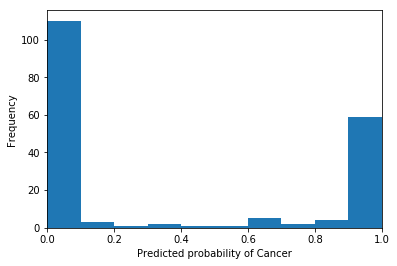

In [37]:
Y_pred_prob = logreg.predict_proba(X_test)[:, 1]

import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(Y_pred_prob)
plt.xlim(0, 1)
plt.xlabel('Predicted probability of Cancer')
plt.ylabel('Frequency')

In [38]:
Y_pred_class_new = np.where(Y_pred_prob > 0.1, 1, 0)
print('accuracy : ', metrics.accuracy_score(Y_test, Y_pred_class_new))
cm4 = metrics.confusion_matrix(Y_test, Y_pred_class_new)
print(cm4)
TP = cm4[1][1]
TN = cm4[0][0]
FP = cm4[0][1]
FN = cm4[1][0]

accuracy :  0.936170212766
[[107   9]
 [  3  69]]


0.987135199524


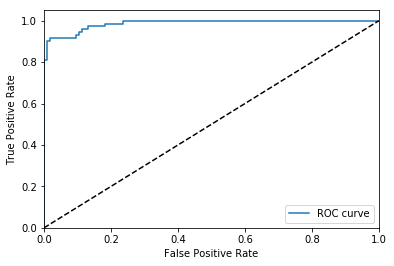

In [29]:
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold
classifier = LogisticRegression(penalty='l1', C=0.2)
Y_score = classifier.fit(X_train, Y_train).decision_function(X_test)

fpr, tpr, _ = roc_curve(Y_test, Y_score)
roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve')
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

The Logistic Regression model seems to have the best fit model holding an accuracy level of 0.987135199524